#Requirements
In this secttion we import the required packages for ttraining our classifier.

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms
import copy

import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import math

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture

from skimage.filters import sobel
from skimage.color import rgb2gray

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

In [2]:
#We mount the google drive. If You are running this notebook locally do nott run this cell. 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Configurations
In this section we define the configs for training. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
DATASET = "Allele B Cropped"
X_PATH = "/content/drive/Shareddrives/Exploding Gradients/x_train_b_cropped.npy"
Y_PATH= "/content/drive/Shareddrives/Exploding Gradients/y_train_b.npy"


BACKBONE = "resnet50"
MULTI_BACKBONE = False
OPTIM = "Adam"
LR =5e-5
SCHEDULER = "None"
EPOCHS = 40
BATCHSIZE = 4
# DROPOUT = [0,0.1,0.2,0.5]
DROPOUT = [0,0.1,0.2,0.5]
AUGMENTATION = "None"

#The following is a list of hyper parameters to test. All Permuttations will be
#tested

WEIGHT_DECAY = [1e-5]
# FREEZE = [10,25,40,50,55]
FREEZE = [50]



#Data Processing
In this section, we read the dataset as a pre saved numpy array. After reading the datset. we divide it into train-testtt sets. We tthen create a pytorch dataset which we will then turn into a dataloader. 

In [ ]:
#We read the 
x = np.load(X_PATH)
y = np.load(Y_PATH)
print("X Tensor Shape: ",x.shape)
print("y Tensor Shape: ",y.shape)

X Tensor Shape:  (285, 4, 200, 1024, 3)
y Tensor Shape:  (285, 1)


In [ ]:
# In this part we draw the pie graph for the distribution of the data with 3 labels
import matplotlib.pyplot as plt

percentages= [np.count_nonzero(y==0),
              np.count_nonzero(y==1),
              np.count_nonzero(y==2)]
              
fig1, ax1 = plt.subplots()
ax1.pie(percentages,labels=["1","2","3"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [ ]:
# We creatte tensors from the numpy arrays
tensor_x = torch.Tensor(x) 
tensor_y = torch.Tensor(y).long()

#initially the data is in the form (Batch, 4Images, Width, Height, Channels)
#We then  change it to (Batch, 4Images,Channels, Width, Height )
tensor_x = torch.swapaxes(tensor_x,2,4)
tensor_x = torch.swapaxes(tensor_x,3,4)


x_train,x_test,y_train,y_test = train_test_split(tensor_x,tensor_y,test_size=0.1)

print("x train shape: ", x_train.shape,"x test shape: ",x_test.shape)
print("x test shape: ",x_test.shape)

validation_dl = TensorDataset(x_validate, nn.functional.one_hot(y_validate,3))
test_ds = TensorDataset(x_test,nn.functional.one_hot(y_test,3)) 
#We shuffle the training set and drop the last of the test set
#This might not be necessary
train_dl = DataLoader(train_ds,BATCHSIZE,shuffle = True)
test_dl = DataLoader(test_ds,BATCHSIZE,drop_last = True)


x train shape:  torch.Size([256, 4, 3, 200, 1024]) x test shape:  torch.Size([29, 4, 3, 200, 1024])


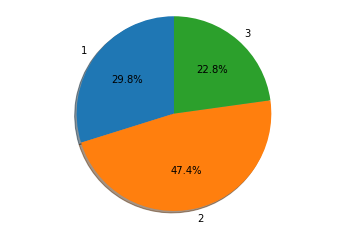

In [9]:
#The following is the distribution of the test set
#We want this to be similar to the dataset as a whole
import matplotlib.pyplot as plt

percentages= [np.count_nonzero(y_test==0),
              np.count_nonzero(y_test==1),
              np.count_nonzero(y_test==2)]
              
fig1, ax1 = plt.subplots()
ax1.pie(percentages,labels=["1","2","3"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

#Classifier
The following section includes the code for the classifier.
We have support for muliple backbones. 


In [ ]:
tensor_x = torch.Tensor(x) 
tensor_y = torch.Tensor(y).long()

tensor_x = torch.swapaxes(tensor_x,2,4)
tensor_x = torch.swapaxes(tensor_x,3,4)

x_train, x_test, y_train, y_test = train_test_split(tensor_x, tensor_y, test_size=0.1, stratify=tensor_y)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train)

print("x train shape: ", x_train.shape, "x validate shape: ", x_validate.shape, "x test shape: ",x_test.shape)

train_ds = TensorDataset(x_train,nn.functional.one_hot(y_train,3))
validation_ds = TensorDataset(x_validate, nn.functional.one_hot(y_validate,3))
test_ds = TensorDataset(x_test,nn.functional.one_hot(y_test,3)) 

train_dl = DataLoader(train_ds, BATCHSIZE, shuffle = True, drop_last = True)
validation_dl = DataLoader(validation_ds, BATCHSIZE)
test_dl = DataLoader(test_ds, BATCHSIZE)
del x,y

In [ ]:
#This function takes in a model and replaces inplace relu layers to an independent relu layer
def reluToInplaceFalse(model):
  for name, child in model.named_children():
    if isinstance(child, nn.ReLU):
      setattr(child, 'inplace', False)
    else:
      reluToInplaceFalse(child)

In [ ]:
#This is the classifier Class.
from torchvision.transforms.transforms import RandomRotation, RandomAdjustSharpness, RandomGrayscale

class Classifier(torch.nn.Module):

  def __init__(self, backbone='resnet', multi_backbone = False, device ="cuda:0",dropout_rate = 0.2, do_augmentation = False):
    super().__init__()
    self.multi_backbone = multi_backbone # Bool: Indicates if we use multibackbone

    #In the following secttion we download the appropriatee prettrained model
    if backbone == "vgg19":
      backbone = torchvision.models.vgg19(pretrained=True)
      self.out_channels = 25088
      
    elif backbone == "resnet18":
      backbone = torchvision.models.resnet18(pretrained=True)
      self.out_channels = 512

    elif backbone == "resnet50":
      backbone = torchvision.models.resnet50(pretrained=True)
      self.out_channels = 2048

    elif backbone == "Efficientnet b1":
      backbone = torchvision.models.efficientnet_b1(pretrained=True)
      self.out_channels = 1280

    elif backbone == "Efficientnet b3":
      backbone = torchvision.models.efficientnet_b3(pretrained=True)
      self.out_channels = 1536

    elif backbone == "Efficientnet b5":
      backbone = torchvision.models.efficientnet_b5(pretrained=True)
      self.out_channels = 2048

    elif backbone == "Efficientnet b7":
      backbone = torchvision.models.efficientnet_b7(pretrained=True)
      self.out_channels = 2560
      
    # Disabling inplace ReLu becasuse GradCam doesn't work it enabled
    reluToInplaceFalse(backbone)
     
    modules = list(backbone.children())[:-1]
    self.do_augmentation = do_augmentation

    if self.do_augmentation: #If augmentation is enabled we  init tthe layer
      self.augmentation = nn.Sequential(transforms.RandomHorizontalFlip(0.2),
                                        # transforms.RandomVerticalFlip(0.2),
                                        # transforms.RandomPerspective(0.2),
                                        RandomRotation(20),
                                        # RandomAdjustSharpness(,),
                                        # RandomGrayscale(),
                                        # transforms.RandomAutocontrast()
      )

    if self.multi_backbone: #We create the backbones and put them on the device
      self.backbone1 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone2 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone3 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone4 = nn.Sequential(*copy.deepcopy(modules)).to(device)

    else:
      self.backbone =  nn.Sequential(*modules).to(device)


     
    #This is the first fully connected layer
    #The output of the backbone goes through this layer before being concatnenated
    self.fc1 = nn.Sequential(nn.Dropout(dropout_rate),
                              nn.Linear(self.out_channels, 256), 
                              nn.ReLU(),
                              nn.Dropout(dropout_rate)) #TODO: Experiment with BN and Dropout
    #This is the final classification layer
    self.fc = nn.Sequential(nn.Linear(1024, 256),
                            nn.ReLU(),
                            nn.Dropout(dropout_rate),
                            nn.Linear(256, 3))                
     
  def forward(self, x, is_training = True): 
    if self.do_augmentation and is_training:
      imgs = [self.augmentation(x[:,i]) for i in range(4)] #list of 4 images
    else:
      imgs = [x[:,i] for i in range(4)] #list of 4 images

    if self.multi_backbone:
      encodings = [self.fc1(self.backbone1(imgs[0]).squeeze()), 
                   self.fc1(self.backbone2(imgs[1]).squeeze()),
                   self.fc1(self.backbone3(imgs[2]).squeeze()),
                   self.fc1(self.backbone4(imgs[3]).squeeze())]
    else:
      encodings = [self.fc1(self.backbone(img).squeeze()) for img in imgs]

    return self.fc(torch.cat(encodings,1))


In [ ]:
#This functtion is responsibl for freezing the early layers of the backbone(s)
def freeze_layers(model,layers = 5):
  if model.multi_backbone:
    for i,param in enumerate(model.backbone1.parameters()):
      pass
    print("This Bacbone has {} parameter layers.".format(i))
    print("Freezing {} Layers.".format(layers))
    for i,param in enumerate(model.backbone1.parameters()):
      if i < layers:
        param.requires_grad = False

    for i,param in enumerate(model.backbone2.parameters()):
      if i < layers:
        param.requires_grad = False

    for i,param in enumerate(model.backbone3.parameters()):
      if i < layers:
        param.requires_grad = False

    for i,param in enumerate(model.backbone4.parameters()):
      if i < layers:
        param.requires_grad = False
  else:
     for i,param in enumerate(model.backbone.parameters()):
      if i < layers:
        param.requires_grad = False



#Training
This secttion containes the code for training the model.

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

def test_model(model, test_dl, criterion):
  test_running_loss = 0.0
  test_running_corrects = 0
  model.eval()
  with torch.no_grad():
    for inputs, labels in test_dl:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs,is_training=False)
      loss = criterion(outputs, labels.squeeze(1).float())
      _, preds = torch.max(outputs, 1)


      test_running_loss += loss.item() * inputs.size(0)
      test_running_corrects += torch.sum(preds == torch.argmax(labels,2).squeeze().data)
  
  eval_loss = test_running_loss / len(test_dl.dataset)
  eval_acc = test_running_corrects.double() / len(test_dl.dataset)
  return eval_loss, eval_acc


def train_model(model, train_dl, validation_dl, test_dl, optimizer, evaluation_steps = 20, epochs =1, savefile='model.pt'):
  writer = SummaryWriter()

  EPOCHS = epochs
  DATA_SIZE =  {"train":len(train_dl.dataset),"eval":len(test_dl.dataset)}

  best_validate_acc = 0
  
  best_validate_loss = float('inf')
  best_validate_loss_step = 0

  final_validate_loss = 0
  final_validate_acc = 0

  # exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  criterion = nn.BCEWithLogitsLoss() #This is the loss function we use
 
  step =0
  model.train()
  for epoch in range(EPOCHS):
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
        model.train()
        for inputs, labels in train_dl:
          model.train()
          optimizer.zero_grad()
      step += 1
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)

          _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels.squeeze(1).float())
      loss.backward()
      optimizer.step()

      # statistics
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == torch.argmax(labels,2).squeeze().data)
      # if phase == 'train':
      #     scheduler.step()
      if step % evaluation_steps == 0:
        validate_loss, validate_acc = test_model(model, validation_dl, criterion)
        writer.add_scalar('Loss/'+"validate", validate_loss, step)
        writer.add_scalar('Accuracy/'+"validate", validate_acc, step)

        if validate_loss < best_validate_loss:
          best_validate_loss = validate_loss
          best_validate_loss_step = step
          best_validate_acc = validate_acc
          torch.save(model, savefile)

        final_validate_acc = validate_acc
        final_validate_loss = validate_loss

            writer.add_scalar('Loss/'+"eval", eval_loss, step)
            writer.add_scalar('Accuracy/'+"eval", eval_acc, step)



    epoch_loss = running_loss / DATA_SIZE["train"]
    epoch_acc = running_corrects.double() / DATA_SIZE["train"]

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            # "Eval", eval_loss, eval_acc))

    final_train_loss = epoch_loss
    final_train_acc = epoch_acc

        # print('Epoch {}/{} '.format(epoch+1, EPOCHS ),'{} Loss: {:.4f} Acc: {:.4f}'.format(
        #       "Train", epoch_loss, epoch_acc))
          
    writer.add_scalar('Loss/'+"Train", epoch_loss, step)
    writer.add_scalar('Accuracy/'+"Train", epoch_acc, step)

  print('Best val Acc: {:4f}\n\n'.format(best_eval_acc))
  test_loss, test_acc = test_model(model, test_dl, criterion)
  return {  "Test Acc": test_acc.cpu().item(),
            "Test Loss": test_loss,
            "Best Validate Acc": best_validate_acc.cpu().item(),
            "Best Validate Loss": best_validate_loss,
            "Best Validate Step": best_validate_loss_step,
            "Final Train Acc": final_train_acc.cpu().item(),
            "Final Eval Acc": final_validate_acc.cpu().item(),
            "Final Train Loss": final_train_loss,
            "Final Eval Loss": final_validate_loss,
        }



In [18]:
#This is an example for training a model
model = Classifier(dropout_rate=0,backbone=BACKBONE,multi_backbone=True,do_augmentation=True).to(device)
freeze_layers(model,80)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_model(model,train_dl,test_dl,optimizer,epochs=10,savefile='model{}{}{}.pt'.format(0.001,50,0.001))

This Bacbone has 158 parameter layers.
Freezing 80 Layers.
Step 20  Eval Loss: 0.6268 Acc: 0.4561
Step 40  Eval Loss: 0.6077 Acc: 0.4561
Epoch 1/10  Train Loss: 0.6160 Acc: 0.5439
Step 60  Eval Loss: 0.6102 Acc: 0.4561
Step 80  Eval Loss: 0.6315 Acc: 0.4561
Step 100  Eval Loss: 0.6145 Acc: 0.4561
Epoch 2/10  Train Loss: 0.5784 Acc: 0.5702
Step 120  Eval Loss: 0.6065 Acc: 0.4561
Step 140  Eval Loss: 0.6104 Acc: 0.4561
Step 160  Eval Loss: 0.6109 Acc: 0.4561
Epoch 3/10  Train Loss: 0.5705 Acc: 0.5702
Step 180  Eval Loss: 0.6087 Acc: 0.4561
Step 200  Eval Loss: 0.6114 Acc: 0.4561
Step 220  Eval Loss: 0.5946 Acc: 0.4561
Epoch 4/10  Train Loss: 0.5594 Acc: 0.5702
Step 240  Eval Loss: 0.5985 Acc: 0.4561
Step 260  Eval Loss: 0.6153 Acc: 0.4561
Step 280  Eval Loss: 0.6050 Acc: 0.4561
Epoch 5/10  Train Loss: 0.5580 Acc: 0.5702
Step 300  Eval Loss: 0.6045 Acc: 0.4561
Step 320  Eval Loss: 0.6035 Acc: 0.4737
Step 340  Eval Loss: 0.5996 Acc: 0.4561
Epoch 6/10  Train Loss: 0.5341 Acc: 0.5702
Step 36

{'Best Eval Acc': 0.5438596491228069,
 'Best Eval Loss': 0.5609051177376195,
 'Best Eval Step': 500,
 'Final Eval Acc': 0.47368421052631576,
 'Final Eval Loss': 0.6217203307570073,
 'Final Train Acc': 0.6535087719298245,
 'Final Train Loss': 0.4547569307318905}

In [ ]:
#This part of the code runs multiple trainings on multiple combination on 
#specified hyperparameters for hyper-parameter tuning 

Sweep_Summary = {
    "Backbone" : [],
    "Multi Backbone": [],
    "Optim" : [],
    "LR" : [],
    "Scheduler" : [],
    "Epochs" : [],
    "Batch Size" : [],
    "Dropout": [],
    "Augmentation": [],
    "Weight Decay": [],
    "Freeze Layers": [],
    "Test Loss": [],
    "Test Acc": [],
    "Best Validate Loss": [],
    "Best Validate Step": [],
    "Best Validate Acc": [],
    "Final Train Acc": [],
    "Final Eval Acc": [],
    "Final Train Loss": [],
    "Final Eval Loss": [],

}


for weight_decay in WEIGHT_DECAY:
  for freeze in FREEZE:
    for dropout_rate in DROPOUT:
      print("Weight Decay {} ".format(weight_decay))
      print("Freeze       {} ".format(freeze))
      print("Dropout Rate {} \n------------------------------------------------------".format(dropout_rate))
      model = Classifier(dropout_rate=dropout_rate,backbone=BACKBONE,multi_backbone=MULTI_BACKBONE).to(device)
      freeze_layers(model,freeze)
      optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
      summary = train_model(model,train_dl,validation_dl,test_dl,optimizer,epochs=EPOCHS,savefile='model{}{}{}.pt'.format(weight_decay,freeze,dropout_rate))

      Sweep_Summary["Backbone"].append(BACKBONE)
      Sweep_Summary["Optim"].append(OPTIM)
      Sweep_Summary["LR"].append(LR)
      Sweep_Summary["Scheduler"].append(SCHEDULER)      
      Sweep_Summary["Epochs"].append(EPOCHS)
      Sweep_Summary["Batch Size"].append(BATCHSIZE)
      Sweep_Summary["Dropout"].append(dropout_rate)
      Sweep_Summary["Augmentation"].append(AUGMENTATION)
      Sweep_Summary["Weight Decay"].append(weight_decay)
      Sweep_Summary["Freeze Layers"].append(freeze)
      Sweep_Summary["Multi Backbone"].append(MULTI_BACKBONE)
      for key,value in summary.items():
        Sweep_Summary[key].append(value)

KeyboardInterrupt: ignored

In [ ]:
#We save the results of the training sweep 
df = pd.DataFrame(Sweep_Summary)
df.to_csv("Fish_Classifier_Sweep_Results.csv")
!cp "/content/Fish_Classifier_Sweep_Results.csv" "/content/drive/MyDrive"
df

/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file


,Backbone,Multi Backbone,Optim,LR,Scheduler,Epochs,Batch Size,Dropout,Augmentation,Weight Decay,Freeze Layers,Best Eval Loss,Best Eval Step,Best Eval Acc,Final Train Acc,Final Eval Acc,Final Train Loss,Final Eval Loss
0,resnet18,False,Adam,0.00005,None,40,4,0.0,None,0.00000,10,0.524519,340,0.586207,0.957031,0.551724,0.071135,0.911740
1,resnet18,False,Adam,0.00005,None,40,4,0.1,None,0.00000,10,0.523889,540,0.655172,0.988281,0.448276,0.027901,1.073272
2,resnet18,False,Adam,0.00005,None,40,4,0.2,None,0.00000,10,0.506876,340,0.620690,0.988281,0.482759,0.042024,0.697343
3,resnet18,False,Adam,0.00005,None,40,4,0.5,None,0.00000,10,0.516705,600,0.620690,0.957031,0.379310,0.116061,0.976772
4,resnet18,False,Adam,0.00005,None,40,4,0.0,None,0.00000,25,0.576749,60,0.551724,1.000000,0.482759,0.022749,1.270029
5,resnet18,False,Adam,0.00005,None,40,4,0.1,None,0.00000,25,0.534919,280,0.586207,0.968750,0.482759,0.061553,0.981142
6,resnet18,False,Adam,0.00005,None,40,4,0.2,None,0.00000,25,0.561822,220,0.586207,0.980469,0.551724,0.056390,0.835536
7,resnet18,False,Adam,0.00005,None,40,4,0.5,None,0.00000,25,0.520022,840,0.586207,0.984375,0.482759,0.054673,0.836594
8,resnet18,False,Adam,0.00005,None,40,4,0.0,None,0.00000,40,0.549737,340,0.586207,0.992188,0.448276,0.033070,0.922413
9,resnet18,False,Adam,0.00005,None,40,4,0.1,None,0.00000,40,0.570477,360,0.586207,0.996094,0.517241,0.022764,1.286257


#Evaluation
In this section we load the ttrained model and test it.

In [19]:
# Test model loading
TRAINED_MODEL_PATH = '/content/model0.001500.001.pt'

saved_model = torch.load(TRAINED_MODEL_PATH)
saved_model = torch.load('model.pt')
saved_model.eval()
test_running_loss = 0.0
all_preds = []
all_labels = []
criterion = nn.BCEWithLogitsLoss()
dl = test_dl
with torch.no_grad():
  for inputs, labels in dl:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = saved_model(inputs,is_training=False)
    loss = criterion(outputs, labels.squeeze(1).float())
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().tolist())
    all_labels.extend([label[0] for label in labels.cpu().tolist()])


    test_running_loss += loss.item() * inputs.size(0)

all_preds = np.array(all_preds)
all_labels = np.argmax(all_labels, axis = 1)

eval_loss = test_running_loss / len(dl.dataset)
eval_acc = accuracy_score(all_labels, all_preds)
print('{} Loss: {:.4f} Acc: {:.4f}'.format("Eval", eval_loss, eval_acc))
print(f'Pred: {all_preds}')
print(f'True: {all_labels}')
print('Confusion Matrix:')
print(confusion_matrix(all_labels, all_preds))

Eval Loss: 0.5953 Acc: 0.5357
Pred: [1 1 1 2 1 1 1 2 1 1 1 2 2 1 1 1 0 1 1 1 1 1 1 2 1 2 1 1 1 2 1 0 1 2 1 1 1
 2 2 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1]
True: [1 0 0 2 1 1 0 2 1 0 0 1 2 0 0 2 1 1 1 2 0 1 1 2 2 2 0 1 1 1 2 0 2 1 1 1 1
 2 0 1 1 0 1 1 2 1 0 1 0 0 1 0 0 1 1 2]
Confusion Matrix:
[[ 1 14  2]
 [ 1 22  3]
 [ 0  6  7]]


In [ ]:
from torchsummary import summary
torch.cuda.empty_cache()
model = Classifier(dropout_rate=dropout_rate,backbone=BACKBONE,multi_backbone=True).to(device)
summary(model, (4, 3, 200, 1000))

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir runs

In [ ]:
!tensorboard dev upload --logdir runs

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs